In [35]:
import pandas as pd
import pyodbc as db
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdates
import numpy as np
import os
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import itertools
from datetime import datetime
from statsmodels.formula.api import ols
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

In [10]:
# Ипорт базы данных в формат данных "пандас.датафрейфм",
# это 2хмерная матрица с заголовками колонок и индексами строк
conn = db.connect('Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=D:\\Kortunov\\transfer\\Esentuk\\РЕЖИМ_по частям.mdb;')
curs = conn.cursor()#эти штуки нужны для работы с базаой курс - это курсор, просто для перемещения по БД
for row in curs.tables(): #этот цикл пробешает по всем таблицам и пишет их имена, просто для навигации
    print(row.table_name)

MSysAccessObjects
MSysAccessXML
MSysACEs
MSysNameMap
MSysNavPaneGroupCategories
MSysNavPaneGroups
MSysNavPaneGroupToObjects
MSysNavPaneObjectIDs
MSysObjects
MSysQueries
MSysRelationships
###___К расчету ГАЗОВЫХ параметров
ДАННЫЕ ДЛЯ ГРАФИКОВ
Описание полей базы
ПОЛЯ БАЗ свойства
Скважины_АО_В РАСЧЕТЫ
Скважины_АО_ТЗ_Устья ВВОД И АНАЛИЗ
Часть 1_Гидродинамика
Часть 2_Химия
Часть 3_Химия_МГУ
###_Выборка скважины для графика ХИМИЯ_НОВЫЙ
Выборка скважины для графика


In [11]:
df_info = pd.read_sql_query("SELECT * FROM [Скважины_АО_В РАСЧЕТЫ];", conn)#Это sql запрос, мы запрашиваем таблицу "все данные"
df_info['IDPN'] = df_info['ID PN']
df_info_IDPN =  df_info[['IDPN','Номер скважины']].copy()
df_info_IDPN

,IDPN,Номер скважины
0,110,418ʹ
1,104,41-бис
2,105,56
3,107,57-РЭ-бис
4,111,1-Э
5,112,2-Э
6,141,55
7,90020,1-КМВ
8,140,1-КМВ-бис
9,106,57-РЭ


In [12]:
df_chem = pd.read_sql_query("SELECT * FROM [Часть 2_Химия];", conn)#Это sql запрос, мы запрашиваем таблицу "все данные"
df_chem

,Year,Month,Day,Hour,Minute,IDPN,ДАТА,pH_водородный_показатель_ID_2201,Ra_(г/литр)_Радиоактивность_ID_7295,Rn_(нКи/литр)_Радиоактивность_ID_7290,...,Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206,Уран_суммарно_U_(грамм_в_литре)_ID_3344,Фенол_(мг_в_литре)_ID_4006,Фторид_F-_(грамм_в_литре)_ID_3303,Характер_запаха_ID_2001,Хлорид_Cl-_(грамм_в_литре)_ID_2301,Хром_суммарно_Cr_(грамм_в_литре)_ID_3430,Цвет_ID_2003,Цианид_CN-_(грамм_в_литре)_ID_2306,Цинк_суммарно_Zn_(грамм_в_литре)_ID_3346
0,1956,10,25,0,0,144,1956-10-25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1956,10,31,0,0,144,1956-10-31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1978,1,1,0,0,97,1978-01-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.5013,NaN,NaN,NaN,NaN
3,1978,1,2,0,0,97,1978-01-02,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.5013,NaN,NaN,NaN,NaN
4,1978,1,2,0,0,101,1978-01-02,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.6388,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35871,2020,10,31,0,0,355,2020-10-31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.8999,NaN,NaN,NaN,NaN
35872,2020,11,1,0,0,355,2020-11-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.8428,NaN,NaN,NaN,NaN
35873,2020,11,2,0,0,355,2020-11-02,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.9999,NaN,NaN,NaN,NaN
35874,2020,11,3,0,0,355,2020-11-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.5857,NaN,NaN,NaN,NaN


In [14]:
df_cond = pd.read_excel('D:\\Kortunov\\transfer\\Esentuk\\Kondicii.xlsx')
df_cond['Номер скважины'] = df_cond['Номер скважины'].astype(str)
df_cond_1 = pd.merge(df_cond,df_info_IDPN, on = 'Номер скважины')
df_cond_1

,Номер скважины,"Минерализация, мин","Минерализация, макс","Углекислота, мин","Углекислота, макс","Борная, мин","Борная, макс","Сероводород, макс","Сероводород, мин",IDPN
0,9,0.5,0.7,NaN,NaN,NaN,NaN,NaN,NaN,6001
1,75-бис,6.0,8.0,1.2,3.0,NaN,NaN,NaN,NaN,6002
2,70,0.5,0.7,NaN,NaN,NaN,NaN,NaN,NaN,10070
3,71,7.0,10.0,0.1,1.8,0.02,0.06,NaN,NaN,10071
4,17-бис,10.0,14.0,1.4,2.9,NaN,NaN,NaN,NaN,97
5,24-бис-1,10.0,14.0,0.1,1.8,0.04,0.08,NaN,NaN,355
6,36-бис,10.0,14.0,1.4,2.9,NaN,NaN,NaN,NaN,243
7,39-бис,7.0,10.0,1.1,2.8,NaN,NaN,NaN,NaN,246
8,418ʹ,7.0,10.0,1.2,1.8,NaN,NaN,NaN,NaN,110
9,418-бис,7.0,10.0,1.1,2.8,NaN,NaN,NaN,NaN,251


In [ ]:
df_info

In [15]:
#df_cond['Номер скважины'] = df_cond['Номер скважины'].astype(str)
wellnumbers = df_cond_1['IDPN'].tolist()
wellnumbers = wellnumbers[0:21]
wellnumbers
wellnames = df_cond_1['Номер скважины'].tolist()
wellnames = wellnames[0:21]
wellnames

['9',
 '75-бис',
 '70',
 '71',
 '17-бис',
 '24-бис-1',
 '36-бис',
 '39-бис',
 '418ʹ',
 '418-бис',
 '33-бис',
 '56',
 '34-бис',
 '41-бис',
 '57-РЭ-бис',
 '1-Э',
 '2-Э',
 '55',
 '1-КМВ-бис',
 '46',
 '49-Э']

In [ ]:
params = {
       'axes.labelsize': 30,
       'font.size': 15,
       'font.sans-serif': 'Arial',
       'legend.fontsize': 23,
       'xtick.labelsize': 25,
       'ytick.labelsize': 25,
       'xtick.direction': 'out',
       'ytick.direction': 'out',
       'text.usetex': False,
       'figure.figsize': [60/2.54, 25/2.54],
       'mathtext.default': 'regular',
       'axes.facecolor': 'white',
       }
#wellnumbers=wellnumbers[7:]
#wellnames=wellnames[7:]
rcParams.update(params)
xlim = ('2019-01')
xlim_max = ('2021-01')
xlim_future=('2030-01')
xlim = datetime.strptime(xlim , '%Y-%m')
xlim_max = datetime.strptime(xlim_max , '%Y-%m')
xlim_future = datetime.strptime(xlim_future , '%Y-%m')
#xlim1 = (2009*365, 2021.5*365)
for a in range(0,len(welllnumbers)):
    print(a)
    print(wellnumbers[a])
    well = df_chem[df_chem['IDPN'] == welllnumbers[a]]
    well = well[(well['ДАТА'] > xlim)]
    well = well[(well['ДАТА'] < xlim_max)]
    #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
    temp = well[['ДАТА','Минерализация_(грамм_в_литре)_ID_2208']].copy()
    temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
    сondizii = df_cond[df_cond["Номер скважины"] == str(wellnames[a])]
    temp = temp.dropna()
    #well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
    m, b = np.polyfit(temp['ДАТА_Числ'],temp['Минерализация_(грамм_в_литре)_ID_2208'], 1)
    fig, ax1 = plt.subplots()
    lns1 = ax1.plot(temp['ДАТА'],temp['Минерализация_(грамм_в_литре)_ID_2208'],'o')
    df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА','Минерализация_(грамм_в_литре)_ID_2208','ДАТА_Числ'])  
    temp = temp.append(df_new_line, ignore_index=True)
    lns2 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+b)

#    lns8=  ax1.axhspan(float(сondizii['Минерализация, мин']), float(сondizii['Минерализация, макс']), facecolor="lightcoral", alpha=0.2,label = 'Кондиции по минерализации',zorder=0)
    
    ax1.annotate('Скважина '+ str(wellnames[a])+ ' ('+str(wellnumbers[a])+')',
        xy=(0.85, 1.1), xycoords='axes fraction',
        horizontalalignment='center', verticalalignment='top',
        fontsize=30, color = 'black') #here goes the annotation of well number and well name in the top right of every subplot
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.set_xlabel('Время (дата), года', color = "black")
    ax1.set_ylabel('Минерализация, г/$дм^3$', color = "black")
    ###############################################################
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    fig.set_facecolor('white')# тут я решил сделать белый фон, а не прозрачный как в прошлом скрипте
    directory = 'D:\\WORK\\MSU\\Esentuk\\figures\\wells\\prognoz_1'
    filename = '\\'+str(wellnames[a])+'_Ten_Years.png'# и рисунок поменял на джипег
    fullpath = directory + filename
    if not os.path.exists(directory):
        os.makedirs(directory)
    keepcharacters = (' ','.','_',')','(','\\',':')
    fullpath2 = "".join(c for c in fullpath if c.isalnum() or c in keepcharacters).rstrip()
    plt.savefig(fullpath2,dpi=300,facecolor='w',bbox_inches = 'tight',pad_inches = 0)#,transparent=True)
    plt.close()
    fig.clf

In [60]:
well = df_chem[df_chem['IDPN'] == welllnumbers[4]]
well = well[(well['ДАТА'] > xlim)]
well = well[(well['ДАТА'] < xlim_max)]
#lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
temp = well[['ДАТА','Минерализация_(грамм_в_литре)_ID_2208']].copy()
temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
сondizii = df_cond[df_cond["Номер скважины"] == str(wellnames[a])]
#well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
m, b = np.polyfit(temp['ДАТА_Числ'],temp['Минерализация_(грамм_в_литре)_ID_2208'], 1)
fig, ax1 = plt.subplots()
lns2 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+b)
lns1 = ax1.plot(temp['ДАТА'],temp['Минерализация_(грамм_в_литре)_ID_2208'],'o')
lns8=  ax1.axhspan(float(сondizii['Минерализация, мин']), float(сondizii['Минерализация, макс']), facecolor="lightcoral", alpha=0.2,label = 'Кондиции по минерализации',zorder=0)
ax1.annotate('Скважина '+ str(wellnames[a])+ ' ('+str(wellnumbers[a])+')',
    xy=(0.85, 1.1), xycoords='axes fraction',
    horizontalalignment='center', verticalalignment='top',
    fontsize=30, color = 'black') #here goes the annotation of well number and well name in the top right of every subplot
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

LinAlgError: SVD did not converge in Linear Least Squares

In [44]:
temp = well[['ДАТА','Минерализация_(грамм_в_литре)_ID_2208']].copy()
temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
temp

,ДАТА,Минерализация_(грамм_в_литре)_ID_2208,ДАТА_Числ
32977,2019-01-29 00:00:00,7.899558,737088.0
33015,2019-02-07 00:00:00,7.772848,737097.0
33044,2019-02-14 00:00:00,7.736413,737104.0
33073,2019-02-21 00:00:00,7.803846,737111.0
33101,2019-02-28 00:00:00,7.852043,737118.0
...,...,...,...
35416,2020-09-17 00:00:00,7.159715,737685.0
35452,2020-09-24 00:00:00,7.346926,737692.0
35495,2020-10-07 00:00:00,6.702895,737705.0
35517,2020-10-15 00:00:00,7.317558,737713.0


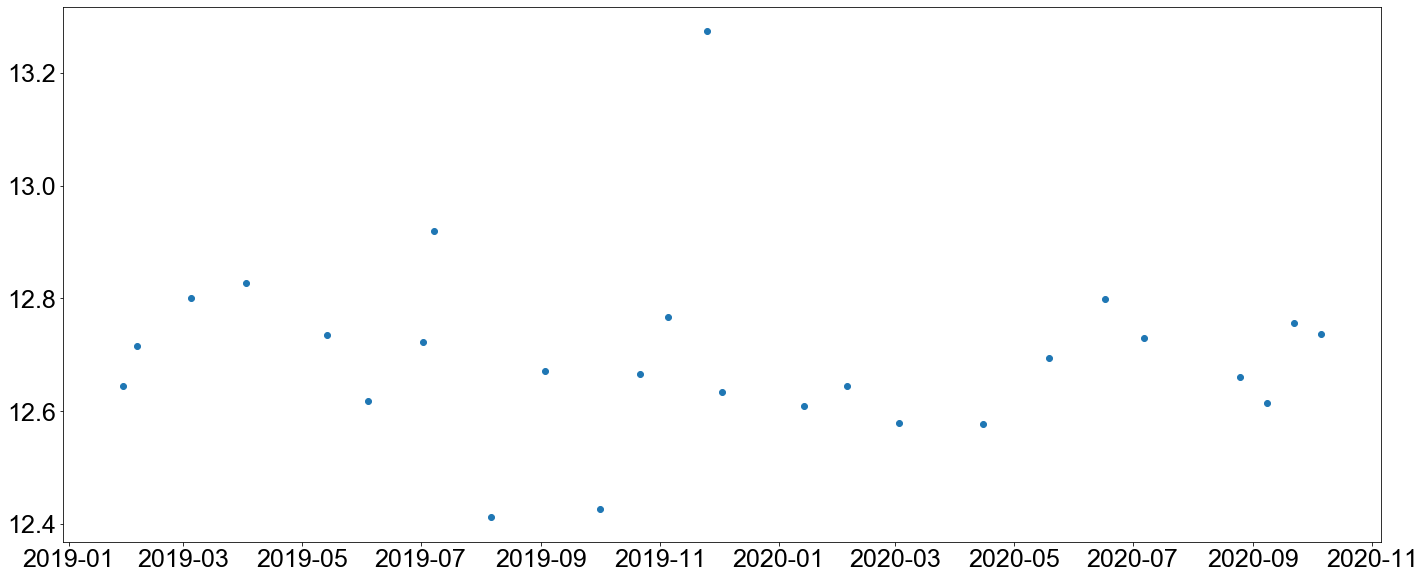

In [58]:
fig, ax1 = plt.subplots()
#lns2 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+b)
lns1 = ax1.plot(temp['ДАТА'],temp['Минерализация_(грамм_в_литре)_ID_2208'],'o')

In [65]:
temp

,ДАТА,Минерализация_(грамм_в_литре)_ID_2208,ДАТА_Числ
32972,2019-01-29 00:00:00,8.325689,737088.0
33011,2019-02-07 00:00:00,8.251060,737097.0
33040,2019-02-14 00:00:00,8.300934,737104.0
33069,2019-02-21 00:00:00,8.329490,737111.0
33097,2019-02-28 00:00:00,8.334253,737118.0
...,...,...,...
35384,2020-09-10 00:00:00,8.122922,737678.0
35411,2020-09-17 00:00:00,8.255055,737685.0
35447,2020-09-24 00:00:00,8.184405,737692.0
35490,2020-10-07 00:00:00,8.399367,737705.0


In [15]:
xlim_future=('2030-01')
xlim_future = datetime.strptime(xlim_future , '%Y-%m')
df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА','Минерализация_(грамм_в_литре)_ID_2208','ДАТА_Числ'])  
temp = temp.append(df_new_line, ignore_index=True)
temp

NameError: name 'temp' is not defined

In [16]:
df_step = pd.read_excel("D:\\Kortunov\\transfer\\Esentuk\\Ступени дебита.xlsx", header = 0)
df_step['ДАТА']=pd.to_datetime(df_step['ДАТА'])

In [23]:
df_step

,ДАТА,IDPN,Этап
0,2019-06-01,97,1
1,2019-06-01,140,0
2,2019-06-01,111,0
3,2019-06-01,355,1
4,2019-06-01,101,1
...,...,...,...
8244,2020-10-31,105,2
8245,2020-10-31,107,2
8246,2020-10-31,10070,4
8247,2020-10-31,10071,6


In [18]:
xlim_future=('2030-01')
xlim_future = datetime.strptime(xlim_future , '%Y-%m')

well = df_chem[df_chem['IDPN'] == 110]
countnulls1 = well['Минерализация_(грамм_в_литре)_ID_2208'].count()
countnulls1

380

In [131]:
well

,Year,Month,Day,Hour,Minute,IDPN,ДАТА,pH_водородный_показатель_ID_2201,Ra_(г/литр)_Радиоактивность_ID_7295,Rn_(нКи/литр)_Радиоактивность_ID_7290,...,Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206,Уран_суммарно_U_(грамм_в_литре)_ID_3344,Фенол_(мг_в_литре)_ID_4006,Фторид_F-_(грамм_в_литре)_ID_3303,Характер_запаха_ID_2001,Хлорид_Cl-_(грамм_в_литре)_ID_2301,Хром_суммарно_Cr_(грамм_в_литре)_ID_3430,Цвет_ID_2003,Цианид_CN-_(грамм_в_литре)_ID_2306,Цинк_суммарно_Zn_(грамм_в_литре)_ID_3346
35490,2020,10,7,0,0,245,2020-10-07 00:00:00,6.76,NaN,NaN,...,6.212,NaN,NaN,0.0015,1.0,1.6259,NaN,1.0,NaN,NaN
35514,2020,10,15,0,0,245,2020-10-15 00:00:00,7.03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.6330,NaN,1.0,NaN,NaN


In [130]:
params = {
       'axes.labelsize': 30,
       'font.size': 15,
       'font.sans-serif': 'Arial',
       'legend.fontsize': 23,
       'xtick.labelsize': 25,
       'ytick.labelsize': 25,
       'xtick.direction': 'out',
       'ytick.direction': 'out',
       'text.usetex': False,
       'figure.figsize': [60/2.54, 25/2.54],
       'mathtext.default': 'regular',
       'axes.facecolor': 'white',
       }
#wellnumbers=wellnumbers[7:]
#wellnames=wellnames[7:]
rcParams.update(params)
xlim_future=('2030-01')
xlim_future = datetime.strptime(xlim_future , '%Y-%m')
for a in range(0,len(wellnumbers)):
    print(a)
    print(wellnumbers[a])
    countnulls1 = 0
    df_step_temp = df_step[df_step['IDPN'] == wellnumbers[a]]
    well = df_chem[df_chem['IDPN'] == wellnumbers[a]]
    well = well[(well['ДАТА'] > df_step_temp['ДАТА'].min())]
    well = well[(well['ДАТА'] < df_step_temp['ДАТА'].max())]
    countnulls1 = well['Минерализация_(грамм_в_литре)_ID_2208'].count()#считаем сколько ненулевых значений в нашей текущей колонке (переменная неправильно названа)
        #countnulls = well['Газовый_фактор_при_НТД_условиям_(м3_в_м3)_ID_7040'].count()
    if countnulls1 > 0:# Если есть хоть одно значение(это можно и менять естсетсвенно) значит строим график

        color = itertools.cycle(("tab:purple", 'forestgreen', 'tab:orange', 'royalblue', 'tab:brown','maroon'))
        color1 = itertools.cycle(("tab:purple", 'forestgreen', 'tab:orange', 'royalblue', 'tab:brown','maroon'))
        stupen_num = itertools.cycle(("Ступень 1", 'Ступень 2', 'Cтупень 3', 'Ступень 4', 'Ступень 5','Ступень 6'))
        marker = itertools.cycle(("d", '+', 'D', 'o', '*',"^","h")) 
        fig, ax1 = plt.subplots()

        #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
        temp = well[['ДАТА','Минерализация_(грамм_в_литре)_ID_2208']].copy()
        temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
        temp = temp.dropna()
        #well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
        m, b = np.polyfit(temp['ДАТА_Числ'],temp['Минерализация_(грамм_в_литре)_ID_2208'], 1)
        df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА','Минерализация_(грамм_в_литре)_ID_2208','ДАТА_Числ'])  
        temp = temp.append(df_new_line, ignore_index=True)
        lns5 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+b, '--',color = 'black', label = 'По всем данным')
        for stupen in range(1,df_step_temp['Этап'].max()+1):
            print("stupen = "+ str(stupen))
            df_step_temp_temp = df_step_temp[(df_step_temp['Этап'] == stupen)]
            xlim = df_step_temp_temp['ДАТА'].min()
            xlim_max = df_step_temp_temp['ДАТА'].max()
            print(str(xlim)+' '+str(xlim_max))
            well = df_chem[df_chem['IDPN'] == wellnumbers[a]]
            well = well[(well['ДАТА'] > xlim)]
            well = well[(well['ДАТА'] < xlim_max)]
            countnulls = well['Минерализация_(грамм_в_литре)_ID_2208'].count()#считаем сколько ненулевых значений в нашей текущей колонке (переменная неправильно названа)
            #countnulls = well['Газовый_фактор_при_НТД_условиям_(м3_в_м3)_ID_7040'].count()
            if countnulls > 0:# Если есть хоть одно значение(это можно и менять естсетсвенно) значит строим график
            #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
                temp = well[['ДАТА','Минерализация_(грамм_в_литре)_ID_2208']].copy()
                temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])

                temp = temp.dropna()
                #well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
                m, b = np.polyfit(temp['ДАТА_Числ'],temp['Минерализация_(грамм_в_литре)_ID_2208'], 1)

                lns1 = ax1.plot(temp['ДАТА'],temp['Минерализация_(грамм_в_литре)_ID_2208'],marker = next(marker), color = next(color), markersize=10, label = next(stupen_num))
                df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА','Минерализация_(грамм_в_литре)_ID_2208','ДАТА_Числ'])  
                temp = temp.append(df_new_line, ignore_index=True)
                lns2 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+b, '--',color = next(color1))



            else:
                next(color)
                next(marker)
                next(color1)
                next(stupen_num)




        ax1.annotate('Скважина '+ str(wellnames[a])+ ' ('+str(wellnumbers[a])+')',
            xy=(0.85, 1.1), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=30, color = 'black') #here goes the annotation of well number and well name in the top right of every subplot
        ax1.xaxis_date()
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax1.set_xlabel('Время (дата), года', color = "black")
        ax1.set_ylabel('Минерализация, г/$дм^3$', color = "black")
        сondizii = df_cond[df_cond["Номер скважины"] == str(wellnames[a])]
        #ax1.set_ylim(float(сondizii['Минерализация, мин'])-5*float(сondizii['Минерализация, мин'])/100,float(сondizii['Минерализация, макс'])+5*float(сondizii['Минерализация, макс'])/100)
        ax1.set_ylim(float(сondizii['Минерализация, мин'])-30*float(сondizii['Минерализация, мин'])/100,float(сondizii['Минерализация, макс'])+30*float(сondizii['Минерализация, макс'])/100) 
        lns8=  ax1.axhspan(float(сondizii['Минерализация, мин']), float(сondizii['Минерализация, макс']), facecolor="lightcoral", alpha=0.2,label = 'Кондиции по минерализации',zorder=0)
        ax1.legend(frameon=False,mode = "expend", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6) 
##############################################################################################################
        plt.tight_layout()
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
        fig.set_facecolor('white')# тут я решил сделать белый фон, а не прозрачный как в прошлом скрипте
        directory = 'D:\\WORK\\MSU\\Esentuk\\figures\\wells\\prognoz_2'
        filename = '\\'+str(wellnames[a])+'_Ten_Years.png'# и рисунок поменял на джипег
        fullpath = directory + filename
        if not os.path.exists(directory):
            os.makedirs(directory)
        keepcharacters = (' ','.','_',')','(','\\',':')
        fullpath2 = "".join(c for c in fullpath if c.isalnum() or c in keepcharacters).rstrip()
        plt.savefig(fullpath2,dpi=300,facecolor='w',bbox_inches = 'tight',pad_inches = 0)#,transparent=True)
        plt.close()
        fig.clf
        # well = well[(well['ДАТА'] > xlim)]
# well = well[(well['ДАТА'] < xlim_max)]
# #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
# temp = well[['ДАТА','Минерализация_(грамм_в_литре)_ID_2208']].copy()
# temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
# сondizii = df_cond[df_cond["Номер скважины"] == str(wellnames[a])]
# temp = temp.dropna()

0
6001
stupen = 1
2020-03-02 00:00:00 2020-05-12 00:00:00
stupen = 2
2020-05-13 00:00:00 2020-09-30 00:00:00
1
6002
stupen = 1
2020-03-02 00:00:00 2020-05-12 00:00:00
stupen = 2
2020-05-13 00:00:00 2020-09-30 00:00:00
2
10070
stupen = 1
2020-02-07 00:00:00 2020-04-13 00:00:00
stupen = 2
2020-04-14 00:00:00 2020-05-12 00:00:00
stupen = 3
2020-05-13 00:00:00 2020-09-10 00:00:00
stupen = 4
2020-09-11 00:00:00 2020-10-31 00:00:00
3
10071
stupen = 1
2019-12-02 00:00:00 2020-03-01 00:00:00
stupen = 2
2020-03-02 00:00:00 2020-03-15 00:00:00
stupen = 3
2020-03-16 00:00:00 2020-08-12 00:00:00
stupen = 4
2020-08-13 00:00:00 2020-09-08 00:00:00
stupen = 5
2020-09-09 00:00:00 2020-10-05 00:00:00
stupen = 6
2020-10-06 00:00:00 2020-10-31 00:00:00
4
97
stupen = 1
2019-06-01 00:00:00 2020-10-31 00:00:00
5
355
stupen = 1
2019-06-01 00:00:00 2019-12-27 00:00:00
stupen = 2
2020-03-03 00:00:00 2020-10-31 00:00:00
6
243
stupen = 1
2019-06-01 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020

C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


7
246
stupen = 1
2019-08-21 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


8
110
9
251
stupen = 1
2019-09-01 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


10
100
stupen = 1
2019-07-24 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


11
105
stupen = 1
2019-06-01 00:00:00 2020-10-01 00:00:00
stupen = 2
2020-10-02 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


12
101
stupen = 1
2019-06-01 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


13
104
stupen = 1
2019-06-03 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


14
107
stupen = 1
2019-06-01 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


15
111
stupen = 1
2019-09-05 00:00:00 2019-11-18 00:00:00
stupen = 2
2019-11-19 00:00:00 2020-09-30 00:00:00
stupen = 3
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


16
112
stupen = 1
2019-09-17 00:00:00 2019-11-17 00:00:00
stupen = 2
2019-11-18 00:00:00 2020-09-30 00:00:00
stupen = 3
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


17
141
stupen = 1
2020-03-11 00:00:00 2020-05-29 00:00:00
stupen = 2
2020-05-30 00:00:00 2020-06-29 00:00:00
stupen = 3
2020-06-30 00:00:00 2020-09-29 00:00:00
stupen = 4
2020-09-30 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


18
140
stupen = 1
2020-03-11 00:00:00 2020-03-31 00:00:00
stupen = 2
2020-04-01 00:00:00 2020-05-23 00:00:00
stupen = 3
2020-05-24 00:00:00 2020-09-30 00:00:00
stupen = 4
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


19
143
stupen = 1
2020-02-13 00:00:00 2020-09-28 00:00:00
stupen = 2
2020-09-29 00:00:00 2020-10-31 00:00:00
20
245
stupen = 1
2020-02-13 00:00:00 2020-09-29 00:00:00
stupen = 2
2020-09-30 00:00:00 2020-10-31 00:00:00


In [68]:
float(сondizii['Минерализация, мин'])

7.0

In [115]:
well['Минерализация_(грамм_в_литре)_ID_2208'].count()

0

In [148]:
temp['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']

KeyError: 'Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303'

In [151]:
params = {
       'axes.labelsize': 30,
       'font.size': 15,
       'font.sans-serif': 'Arial',
       'legend.fontsize': 23,
       'xtick.labelsize': 25,
       'ytick.labelsize': 25,
       'xtick.direction': 'out',
       'ytick.direction': 'out',
       'text.usetex': False,
       'figure.figsize': [60/2.54, 25/2.54],
       'mathtext.default': 'regular',
       'axes.facecolor': 'white',
       }
#wellnumbers=wellnumbers[7:]
#wellnames=wellnames[7:]
rcParams.update(params)
xlim_future=('2030-01')
xlim_future = datetime.strptime(xlim_future , '%Y-%m')
for a in range(0,len(wellnumbers)):
    print(a)
    print(wellnumbers[a])
    countnulls1 = 0
    df_step_temp = df_step[df_step['IDPN'] == wellnumbers[a]]
    well = df_chem[df_chem['IDPN'] == wellnumbers[a]]
    well = well[(well['ДАТА'] > df_step_temp['ДАТА'].min())]
    well = well[(well['ДАТА'] < df_step_temp['ДАТА'].max())]
    countnulls1 = well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'].count()#считаем сколько ненулевых значений в нашей текущей колонке (переменная неправильно названа)
        #countnulls = well['Газовый_фактор_при_НТД_условиям_(м3_в_м3)_ID_7040'].count()
    if countnulls1 > 0:# Если есть хоть одно значение(это можно и менять естсетсвенно) значит строим график

        color = itertools.cycle(("tab:purple", 'forestgreen', 'tab:orange', 'royalblue', 'tab:brown','maroon'))
        color1 = itertools.cycle(("tab:purple", 'forestgreen', 'tab:orange', 'royalblue', 'tab:brown','maroon'))
        stupen_num = itertools.cycle(("Ступень 1", 'Ступень 2', 'Cтупень 3', 'Ступень 4', 'Ступень 5','Ступень 6'))
        marker = itertools.cycle(("d", '+', 'D', 'o', '*',"^","h")) 
        fig, ax1 = plt.subplots()

        #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
        #well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] =well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] + 0.5*well['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']
        
        temp = well[['ДАТА','Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206','Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']].groupby("ДАТА").mean().copy()
        temp['ДАТА'] = temp.index
        temp = temp.reset_index(drop=True)
        temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
        temp = temp.dropna()
        temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] =temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] + 0.5*temp['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']
        #well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
        m, b = np.polyfit(temp['ДАТА_Числ'],temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'], 1)
        df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА','Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206','ДАТА_Числ'])  
        temp = temp.append(df_new_line, ignore_index=True)
        lns5 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+b, '--',color = 'black', label = 'По всем данным')
        for stupen in range(1,df_step_temp['Этап'].max()+1):
            print("stupen = "+ str(stupen))
            df_step_temp_temp = df_step_temp[(df_step_temp['Этап'] == stupen)]
            xlim = df_step_temp_temp['ДАТА'].min()
            xlim_max = df_step_temp_temp['ДАТА'].max()
            print(str(xlim)+' '+str(xlim_max))
            well = df_chem[df_chem['IDPN'] == wellnumbers[a]]
            well = well[(well['ДАТА'] > xlim)]
            well = well[(well['ДАТА'] < xlim_max)]
            countnulls = well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'].count()#считаем сколько ненулевых значений в нашей текущей колонке (переменная неправильно названа)
            #countnulls = well['Газовый_фактор_при_НТД_условиям_(м3_в_м3)_ID_7040'].count()
            if countnulls > 0:# Если есть хоть одно значение(это можно и менять естсетсвенно) значит строим график
            #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
                temp = well[['ДАТА','Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206','Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']].groupby("ДАТА").mean().copy()
                temp['ДАТА'] = temp.index
                temp = temp.reset_index(drop=True)
                temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
                temp = temp.dropna()
                temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] =temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] + 0.5*temp['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']
                #well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
                m, b = np.polyfit(temp['ДАТА_Числ'],temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'], 1)

                lns1 = ax1.plot(temp['ДАТА'],temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'],marker = next(marker), color = next(color), markersize=10, label = next(stupen_num))
                df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА','Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206','ДАТА_Числ'])  
                temp = temp.append(df_new_line, ignore_index=True)
                lns2 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+b, '--',color = next(color1))



            else:
                next(color)
                next(marker)
                next(color1)
                next(stupen_num)




        ax1.annotate('Скважина '+ str(wellnames[a])+ ' ('+str(wellnumbers[a])+')',
            xy=(0.85, 1.1), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='top',
            fontsize=30, color = 'black') #here goes the annotation of well number and well name in the top right of every subplot
        ax1.xaxis_date()
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax1.set_xlabel('Время (дата), года', color = "black")
        ax1.set_ylabel('Минерализация, г/$дм^3$', color = "black")
        сondizii = df_cond[df_cond["Номер скважины"] == str(wellnames[a])]
        #ax1.set_ylim(float(сondizii['Минерализация, мин'])-5*float(сondizii['Минерализация, мин'])/100,float(сondizii['Минерализация, макс'])+5*float(сondizii['Минерализация, макс'])/100)
        ax1.set_ylim(float(сondizii['Минерализация, мин'])-35*float(сondizii['Минерализация, мин'])/100,float(сondizii['Минерализация, макс'])+30*float(сondizii['Минерализация, макс'])/100) 
        lns8=  ax1.axhspan(float(сondizii['Минерализация, мин']), float(сondizii['Минерализация, макс']), facecolor="lightcoral", alpha=0.2,label = 'Кондиции по минерализации',zorder=0)
        ax1.legend(frameon=False,mode = "expend", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6) 
##############################################################################################################
        
        plt.tight_layout()
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
        fig.set_facecolor('white')# тут я решил сделать белый фон, а не прозрачный как в прошлом скрипте
        directory = 'D:\\WORK\\MSU\\Esentuk\\figures\\wells\\prognoz_3'
        filename = '\\'+str(wellnames[a])+'_Ten_Years.png'# и рисунок поменял на джипег
        fullpath = directory + filename
        if not os.path.exists(directory):
            os.makedirs(directory)
        keepcharacters = (' ','.','_',')','(','\\',':')
        fullpath2 = "".join(c for c in fullpath if c.isalnum() or c in keepcharacters).rstrip()
        plt.savefig(fullpath2,dpi=300,facecolor='w',bbox_inches = 'tight',pad_inches = 0)#,transparent=True)
        plt.close()
        fig.clf
        # well = well[(well['ДАТА'] > xlim)]
# well = well[(well['ДАТА'] < xlim_max)]
# #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
# temp = well[['ДАТА','Минерализация_(грамм_в_литре)_ID_2208']].copy()
# temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
# сondizii = df_cond[df_c

0
6001
stupen = 1
2020-03-02 00:00:00 2020-05-12 00:00:00
stupen = 2
2020-05-13 00:00:00 2020-09-30 00:00:00
1
6002
stupen = 1
2020-03-02 00:00:00 2020-05-12 00:00:00
stupen = 2
2020-05-13 00:00:00 2020-09-30 00:00:00
2
10070
stupen = 1
2020-02-07 00:00:00 2020-04-13 00:00:00
stupen = 2
2020-04-14 00:00:00 2020-05-12 00:00:00
stupen = 3
2020-05-13 00:00:00 2020-09-10 00:00:00
stupen = 4
2020-09-11 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


3
10071
stupen = 1
2019-12-02 00:00:00 2020-03-01 00:00:00
stupen = 2
2020-03-02 00:00:00 2020-03-15 00:00:00
stupen = 3
2020-03-16 00:00:00 2020-08-12 00:00:00
stupen = 4
2020-08-13 00:00:00 2020-09-08 00:00:00
stupen = 5
2020-09-09 00:00:00 2020-10-05 00:00:00
stupen = 6
2020-10-06 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


4
97
stupen = 1
2019-06-01 00:00:00 2020-10-31 00:00:00
5
355
stupen = 1
2019-06-01 00:00:00 2019-12-27 00:00:00
stupen = 2
2020-03-03 00:00:00 2020-10-31 00:00:00
6
243
stupen = 1
2019-06-01 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


7
246
stupen = 1
2019-08-21 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


8
110
9
251
stupen = 1
2019-09-01 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


10
100
stupen = 1
2019-07-24 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


11
105
stupen = 1
2019-06-01 00:00:00 2020-10-01 00:00:00
stupen = 2
2020-10-02 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


12
101
stupen = 1
2019-06-01 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


13
104
stupen = 1
2019-06-03 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


14
107
stupen = 1
2019-06-01 00:00:00 2020-09-30 00:00:00
stupen = 2
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


15
111
stupen = 1
2019-09-05 00:00:00 2019-11-18 00:00:00
stupen = 2
2019-11-19 00:00:00 2020-09-30 00:00:00
stupen = 3
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


16
112
stupen = 1
2019-09-17 00:00:00 2019-11-17 00:00:00
stupen = 2
2019-11-18 00:00:00 2020-09-30 00:00:00
stupen = 3
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


17
141
stupen = 1
2020-03-11 00:00:00 2020-05-29 00:00:00
stupen = 2
2020-05-30 00:00:00 2020-06-29 00:00:00
stupen = 3
2020-06-30 00:00:00 2020-09-29 00:00:00
stupen = 4
2020-09-30 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


18
140
stupen = 1
2020-03-11 00:00:00 2020-03-31 00:00:00
stupen = 2
2020-04-01 00:00:00 2020-05-23 00:00:00
stupen = 3
2020-05-24 00:00:00 2020-09-30 00:00:00
stupen = 4
2020-10-01 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


19
143
stupen = 1
2020-02-13 00:00:00 2020-09-28 00:00:00
stupen = 2
2020-09-29 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


20
245
stupen = 1
2020-02-13 00:00:00 2020-09-29 00:00:00
stupen = 2
2020-09-30 00:00:00 2020-10-31 00:00:00


C:\Users\Hydro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
#df_cond['Номер скважины'] = df_cond['Номер скважины'].astype(str)
wellnumbers = df_cond_1['IDPN'].tolist()
wellnumbers = wellnumbers[0:21]
wellnumbers
wellnames = df_cond_1['Номер скважины'].tolist()
wellnames = wellnames[0:21]
wellnames

['9',
 '75-бис',
 '70',
 '71',
 '17-бис',
 '24-бис-1',
 '36-бис',
 '39-бис',
 '418ʹ',
 '418-бис',
 '33-бис',
 '56',
 '34-бис',
 '41-бис',
 '57-РЭ-бис',
 '1-Э',
 '2-Э',
 '55',
 '1-КМВ-бис',
 '46',
 '49-Э']

In [56]:
wellnumbers = [140]
wellnames = ['1-КМВ-БИС']

In [197]:
test= test[test['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'].notna()]
test = test[['ДАТА','ДАТА_Числ','Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206']]
test.to_csv(fullpath2, index=False,encoding= 'utf-8-sig')


In [244]:
test = test[test['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'].notna()]
test['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'].count()

58

In [51]:
#log
params = {
       'axes.labelsize': 30,
       'font.size': 15,
       'font.sans-serif': 'Arial',
       'legend.fontsize': 23,
       'xtick.labelsize': 25,
       'ytick.labelsize': 25,
       'xtick.direction': 'out',
       'ytick.direction': 'out',
       'text.usetex': False,
       'figure.figsize': [60/2.54, 25/2.54],
       'mathtext.default': 'regular',
       'axes.facecolor': 'white',
       }
#wellnumbers=wellnumbers[7:]
#wellnames=wellnames[7:]
rcParams.update(params)
out = []
df_out = pd.DataFrame()
out1 = []
xlim_future=('2030-01')
xlim_future = datetime.strptime(xlim_future , '%Y-%m')
listofdata = []
columnames = ['Магний-ион_Mg++_(грамм_в_литре)_ID_2404']
#columnames = ['Азот_N2_в_спонтанной_газовой_фазе_(%V)_ID_3507','метан_CH4_в_спонтанной_газовой_фазе_(%V)_ID_3508','Азот+метан_в_спонтанной_газовой_фазе_(%V)_ID_7067','Двуокись_CO2_в_спонтанной_газовой_фазе(%V)_ID_7066','Калий_ион_K+_(грамм_в_литре)_ID_2402','Натрий-ион_Na+_(грамм_в_литре)_ID_2401','Сумма_катионов_Na+_и_K+_(грамм_в_литре)_ID_2403','Магний-ион_Mg++_(грамм_в_литре)_ID_2404','Кальций-ион_Ca++_(грамм_в_литре)_ID_2405','Железо_суммарно_Fe_(грамм_в_литре)_ID_2409','Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303','Сульфат_SO4--_(грамм_в_литре)_ID_2302','Хлорид_Cl-_(грамм_в_литре)_ID_2301','Минерализация_(грамм_в_литре)_ID_2208','Метакремниевая_кислота_H3SiO3_(грамм/литр)_ID_7007','Борная_кислота_H3BO3_(грамм_в_литре)_ID_5005','Двуокись_CO2_РАСТВОРЕННАЯ_(грамм_в_литре)_СБОРНАЯ','Сероводород_H2S_ОБЩИЙ_(грамм_в_литре)_ID_3504','pH_водородный_показатель_ID_2201','Фторид_F-_(грамм_в_литре)_ID_3303','Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206','Иодид_I-_(грамм_в_литре)_ID_3302','Бромид_Br-_(грамм_в_литре)_ID_3301']
for a in range(0,len(wellnumbers)):
    print(a)
    print(wellnumbers[a])
    countnulls1 = 0
    df_step_temp = df_step[df_step['IDPN'] == wellnumbers[a]]
    
    for b in range(0,len(columnames)):
        well = df_chem[df_chem['IDPN'] == wellnumbers[a]].copy()
        well[columnames[b]] = well[columnames[b]].mask((well[columnames[b]] - well[columnames[b]].mean()).abs() > 3 * well[columnames[b]].std())
        well[columnames[b]] = well[columnames[b]].mask((well[columnames[b]] - well[columnames[b]].mean()).abs() > 3 * well[columnames[b]].std())
        well = well[(well['ДАТА'] > df_step_temp['ДАТА'].min())]
        well = well[(well['ДАТА'] < df_step_temp['ДАТА'].max())]
        countnulls1 = well[columnames[b]].count()
#        countnulls1 = well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'].count()#считаем сколько ненулевых значений в нашей текущей колонке (переменная неправильно названа)
            #countnulls = well['Газовый_фактор_при_НТД_условиям_(м3_в_м3)_ID_7040'].count()
        if countnulls1 > 0:# Если есть хоть одно значение(это можно и менять естсетсвенно) значит строим график
            model = 'nodata'
            color = itertools.cycle(("tab:purple", 'forestgreen', 'tab:orange', 'royalblue', 'tab:brown','maroon'))
            color1 = itertools.cycle(("tab:purple", 'forestgreen', 'tab:orange', 'royalblue', 'tab:brown','maroon'))
            stupen_num = itertools.cycle(("Ступень 1", 'Ступень 2', 'Cтупень 3', 'Ступень 4', 'Ступень 5','Ступень 6'))
            marker = itertools.cycle(("d", '+', 'D', 'o', '*',"^","h")) 
#            fig, ax1 = plt.subplots()

            #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
            #well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] =well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] + 0.5*well['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']

            temp = well.groupby("ДАТА").mean().copy()
            
            temp['ДАТА'] = temp.index
            temp = temp.reset_index(drop=True)
            temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])-737210.0
            test = temp.copy()
            temp = temp[temp[columnames[b]].notna()]
#            temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] =temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] + 0.5*temp['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']
            #well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
            
            model =scipy.stats.linregress(np.log10(temp['ДАТА_Числ']),temp[columnames[b]])
            #results = model.fit()
            m,bb = model.slope, model.intercept
#            print(model.pvalue)
     #       m, b = np.polyfit(temp['ДАТА_Числ'],temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'], 1)
            df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА',columnames[b],'ДАТА_Числ'])  
            temp = temp.append(df_new_line, ignore_index=True)
            out = [wellnumbers[a],wellnames[a],columnames[b],countnulls1,model.pvalue,model.rvalue*model.rvalue,model.slope,model.intercept]
            
#            lns5 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+bb, '--',color = 'black', label = 'По всем данным')
            out1 = []
            for stupen in range(1,df_step['Этап'].max()+1):
                model = 'nodata'
#                print("stupen = "+ str(stupen))
                df_step_temp_temp = df_step_temp[(df_step_temp['Этап'] == stupen)]
                xlim = df_step_temp_temp['ДАТА'].min()
                xlim_max = df_step_temp_temp['ДАТА'].max()
#                print(str(xlim)+' '+str(xlim_max))
                well = df_chem[df_chem['IDPN'] == wellnumbers[a]].copy()
                well[columnames[b]] = well[columnames[b]].mask((well[columnames[b]] - well[columnames[b]].mean()).abs() > 3 * well[columnames[b]].std())
                well[columnames[b]] = well[columnames[b]].mask((well[columnames[b]] - well[columnames[b]].mean()).abs() > 3 * well[columnames[b]].std())
                well = well[(well['ДАТА'] > xlim)]
                well = well[(well['ДАТА'] < xlim_max)]
                countnulls = well[columnames[b]].count()#считаем сколько ненулевых значений в нашей текущей колонке (переменная неправильно названа)
                #countnulls = well['Газовый_фактор_при_НТД_условиям_(м3_в_м3)_ID_7040'].count()
                if countnulls > 0:# Если есть хоть одно значение(это можно и менять естсетсвенно) значит строим график
                    temp = well.groupby("ДАТА").mean().copy()
                    temp['ДАТА'] = temp.index
                    temp = temp.reset_index(drop=True)
                    temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])-737210.0
                    temp = temp[temp[columnames[b]].notna()]
#                    temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] =temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] + 0.5*temp['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']
                    #well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
                    model =scipy.stats.linregress(np.log10(temp['ДАТА_Числ']),temp[columnames[b]])
                    #results = model.fit()
                    m,bb = model.slope, model.intercept
#                    print(model.pvalue)
#                    lns1 = ax1.plot(temp['ДАТА'],temp[columnames[b]],marker = next(marker), color = next(color), markersize=10, label = next(stupen_num))
                    df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА',columnames[b],'ДАТА_Числ'])  
                    temp = temp.append(df_new_line, ignore_index=True)
#                    lns2 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+bb, '--',color = next(color1))
                    out1.append(countnulls)
                    out1.append(model.pvalue)#,model.pvalue]
                    out1.append(model.rvalue*model.rvalue)
                    out1.append(model.slope)
                    out1.append(model.intercept)


                else:
                    next(color)
                    next(marker)
                    next(color1)
                    next(stupen_num)
                    out1.append(countnulls)
                    out1.append(model)
                    out1.append(model)
                    out1.append(model)
                    out1.append(model)
                 
            out = out+out1
            listofdata.append(out)
            print(out)
df_out=pd.DataFrame(listofdata,columns=['IDPN','Номер скважины','parametr','Выборка с начала опыта','p-value','R2','Slope','intercept','Выборка Ступень 1','p-value','R2','Slope','intercept',\
                                            'Выборка Ступень 2','p-value','R2','Slope','intercept','Выборка Ступень 3',\
                                            'p-value','R2','Slope','intercept','Выборка Ступень 4','p-value','R2','Slope','intercept','Выборка Ступень 5','p-value','R2','Slope','intercept','Выборка Ступень 6','p-value','R2','Slope','intercept'])
directory = 'D:\\WORK\\MSU\\Esentuk\\t_test'
#        filename = '\\'+str(wellnames[a])# и рисунок поменял на джипег
filename = '\\'+'t_test__since_nachalo_opita_log_71_n.csv'# и рисунок поменял на джипег
fullpath = directory + filename
if not os.path.exists(directory):
    os.makedirs(directory)
keepcharacters = (' ','.','_',')','(','\\',':')
fullpath2 = "".join(c for c in fullpath if c.isalnum() or c in keepcharacters).rstrip()
df_out.to_csv(fullpath2, index=False,encoding= 'utf-8-sig')


#             ax1.annotate('Скважина '+ str(wellnames[a])+ ' ('+str(wellnumbers[a])+')',
#                 xy=(0.85, 1.1), xycoords='axes fraction',
#                 horizontalalignment='center', verticalalignment='top',
#                 fontsize=30, color = 'black') #here goes the annotation of well number and well name in the top right of every subplot
#             ax1.xaxis_date()
#             ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#             ax1.set_xlabel('Время (дата), года', color = "black")
#             ax1.set_ylabel('Минерализация, г/$дм^3$', color = "black")
#             сondizii = df_cond[df_cond["Номер скважины"] == str(wellnames[a])]
#             #ax1.set_ylim(float(сondizii['Минерализация, мин'])-5*float(сondizii['Минерализация, мин'])/100,float(сondizii['Минерализация, макс'])+5*float(сondizii['Минерализация, макс'])/100)
# #            ax1.set_ylim(float(сondizii['Минерализация, мин'])-15*float(сondizii['Минерализация, мин'])/100,float(сondizii['Минерализация, макс'])+15*float(сondizii['Минерализация, макс'])/100) 
#             lns8=  ax1.axhspan(float(сondizii['Минерализация, мин']), float(сondizii['Минерализация, макс']), facecolor="lightcoral", alpha=0.2,label = 'Кондиции по минерализации',zorder=0)
#             ax1.legend(frameon=False,mode = "expend", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6) 
    ##############################################################################################################

    #         plt.tight_layout()
    #         plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    #         fig.set_facecolor('white')# тут я решил сделать белый фон, а не прозрачный как в прошлом скрипте
    #         directory = 'D:\\WORK\\MSU\\Esentuk\\figures\\wells\\prognoz_3'
    #         filename = '\\'+str(wellnames[a])+'_Ten_Years.png'# и рисунок поменял на джипег
    #         fullpath = directory + filename
    #         if not os.path.exists(directory):
    #             os.makedirs(directory)
    #         keepcharacters = (' ','.','_',')','(','\\',':')
    #         fullpath2 = "".join(c for c in fullpath if c.isalnum() or c in keepcharacters).rstrip()
    #         plt.savefig(fullpath2,dpi=300,facecolor='w',bbox_inches = 'tight',pad_inches = 0)#,transparent=True)
    #         plt.close()
    #         fig.clf
    #        plt.show()
            # well = well[(well['ДАТА'] > xlim)]
    # well = well[(well['ДАТА'] < xlim_max)]
    # #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
    # temp = well[['ДАТА','Минерализация_(грамм_в_литре)_ID_2208']].copy()
    # temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
    # сondizii = df_cond[df_c

0
11071
[11071, '71-н', 'метан_CH4_в_спонтанной_газовой_фазе_(%V)_ID_3508', 4, 0.12051219531195827, 0.7734987985949909, -82.32503689780258, 245.83064131260159, 2, 0.0, 1.0, -69.71008395505956, 213.13738200835706, 1, nan, 0.0, nan, nan, 1, nan, 0.0, nan, nan, 0, 'nodata', 'nodata', 'nodata', 'nodata', 0, 'nodata', 'nodata', 'nodata', 'nodata', 0, 'nodata', 'nodata', 'nodata', 'nodata']
[11071, '71-н', 'Двуокись_CO2_в_спонтанной_газовой_фазе(%V)_ID_7066', 4, 0.03695521897061606, 0.9274552502679341, 124.86990771110946, -260.17043410789927, 2, 0.0, 1.0, 104.56512593258934, -207.20607301253563, 1, nan, 0.0, nan, nan, 1, nan, 0.0, nan, nan, 0, 'nodata', 'nodata', 'nodata', 'nodata', 0, 'nodata', 'nodata', 'nodata', 'nodata', 0, 'nodata', 'nodata', 'nodata', 'nodata']
[11071, '71-н', 'Сумма_катионов_Na+_и_K+_(грамм_в_литре)_ID_2403', 13, 6.367215819239257e-06, 0.8540053303484886, 3.6808307213265863, -7.116933661753331, 7, 0.11407926014121209, 0.4223732147806695, 2.0409734891301037, -2.7992051

In [52]:
temp['ДАТА_Числ']

0       432.0
1       459.0
2    741078.0
Name: ДАТА_Числ, dtype: float64

In [39]:
mdates.date2num(datetime.strptime('1970-01-01', '%Y-%m-%d'))

719163.0

In [48]:
mdates.date2num(datetime.strptime('2019-06-01', '%Y-%m-%d'))-mdates.date2num(datetime.strptime('0001-01-01', '%Y-%m-%d'))

737210.0

In [269]:
test

,Year,Month,Day,Hour,Minute,IDPN,pH_водородный_показатель_ID_2201,Ra_(г/литр)_Радиоактивность_ID_7295,Rn_(нКи/литр)_Радиоактивность_ID_7290,U_(г/литр)_Радиоактивность_ID_7300,...,Фенол_(мг_в_литре)_ID_4006,Фторид_F-_(грамм_в_литре)_ID_3303,Характер_запаха_ID_2001,Хлорид_Cl-_(грамм_в_литре)_ID_2301,Хром_суммарно_Cr_(грамм_в_литре)_ID_3430,Цвет_ID_2003,Цианид_CN-_(грамм_в_литре)_ID_2306,Цинк_суммарно_Zn_(грамм_в_литре)_ID_3346,ДАТА,ДАТА_Числ
0,2019,6,6,0,0,140,6.85,NaN,NaN,NaN,...,NaN,NaN,NaN,0.8769,NaN,NaN,NaN,NaN,2019-06-06,18053.0
1,2019,6,13,0,0,140,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.8662,NaN,NaN,NaN,NaN,2019-06-13,18060.0
2,2019,6,20,0,0,140,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.8662,NaN,NaN,NaN,NaN,2019-06-20,18067.0
3,2019,6,28,0,0,140,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.8857,NaN,NaN,NaN,NaN,2019-06-28,18075.0
4,2019,7,4,0,0,140,6.64,NaN,NaN,NaN,...,NaN,NaN,NaN,0.8628,NaN,NaN,NaN,NaN,2019-07-04,18081.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2020,9,17,0,0,140,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-17,18522.0
64,2020,9,24,0,0,140,7.03,NaN,NaN,NaN,...,NaN,0.0006,5.0,0.8574,0.00002,1.0,NaN,5.000000e-07,2020-09-24,18529.0
65,2020,9,28,0,0,140,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-28,18533.0
66,2020,10,8,0,0,140,6.68,NaN,NaN,NaN,...,NaN,NaN,NaN,0.8591,NaN,NaN,NaN,NaN,2020-10-08,18543.0


In [275]:
test= test[test['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'].notna()]
a =scipy.stats.linregress(np.log(test['ДАТА_Числ']),test['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'])
#results = model.fit()
#m,b = a.slope, a.intercept
print(a.stderr)
print(a.pvalue)
#.rvalue*a.rvalue
m, b 

1.3264960712160672
0.04845962871344187


(nan, 0)

In [267]:
temp

,Year,Month,Day,Hour,Minute,IDPN,pH_водородный_показатель_ID_2201,Ra_(г/литр)_Радиоактивность_ID_7295,Rn_(нКи/литр)_Радиоактивность_ID_7290,U_(г/литр)_Радиоактивность_ID_7300,...,Фенол_(мг_в_литре)_ID_4006,Фторид_F-_(грамм_в_литре)_ID_3303,Характер_запаха_ID_2001,Хлорид_Cl-_(грамм_в_литре)_ID_2301,Хром_суммарно_Cr_(грамм_в_литре)_ID_3430,Цвет_ID_2003,Цианид_CN-_(грамм_в_литре)_ID_2306,Цинк_суммарно_Zn_(грамм_в_литре)_ID_3346,ДАТА,ДАТА_Числ
0,2020.0,5.0,28.0,0.0,0.0,140.0,6.77,NaN,NaN,NaN,...,NaN,0.00080,1.0,0.8724,0.00002,1.0,NaN,1.500000e-05,2020-05-28,18410.0
1,2020.0,6.0,4.0,0.0,0.0,140.0,6.73,NaN,NaN,NaN,...,NaN,0.00070,1.0,0.8777,0.00002,1.0,NaN,5.000000e-07,2020-06-04,18417.0
2,2020.0,7.0,9.0,0.0,0.0,140.0,6.64,NaN,NaN,NaN,...,NaN,0.00070,1.0,0.8751,0.00002,1.0,NaN,4.500000e-06,2020-07-09,18452.0
3,2020.0,8.0,6.0,0.0,0.0,140.0,6.85,NaN,NaN,NaN,...,NaN,0.00044,NaN,0.8773,NaN,2.0,NaN,NaN,2020-08-06,18480.0
4,2020.0,8.0,13.0,0.0,0.0,140.0,6.56,NaN,NaN,NaN,...,NaN,0.00060,1.0,0.8671,0.00002,1.0,NaN,NaN,2020-08-13,18487.0
5,2020.0,9.0,3.0,0.0,0.0,140.0,6.80,NaN,NaN,NaN,...,NaN,0.00058,1.0,0.8578,0.00001,1.5,0.00001,6.525000e-05,2020-09-03,18508.0
6,2020.0,9.0,24.0,0.0,0.0,140.0,7.03,NaN,NaN,NaN,...,NaN,0.00060,5.0,0.8574,0.00002,1.0,NaN,5.000000e-07,2020-09-24,18529.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2030-01-01,21915.0


In [274]:
test= test[test['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'].notna()]
test = test[['ДАТА','ДАТА_Числ','Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206']]
test.to_csv('C:\\Users\\ekort\\WORK\\Essentuk\\t_test\\test.csv', index=False,encoding= 'utf-8-sig')

In [57]:
#log
params = {
       'axes.labelsize': 30,
       'font.size': 15,
       'font.sans-serif': 'Arial',
       'legend.fontsize': 23,
       'xtick.labelsize': 25,
       'ytick.labelsize': 25,
       'xtick.direction': 'out',
       'ytick.direction': 'out',
       'text.usetex': False,
       'figure.figsize': [60/2.54, 25/2.54],
       'mathtext.default': 'regular',
       'axes.facecolor': 'white',
       }
#wellnumbers=wellnumbers[7:]
#wellnames=wellnames[7:]
rcParams.update(params)
out = []
df_out = pd.DataFrame()
out1 = []
xlim_future=('2030-01')
xlim_future = datetime.strptime(xlim_future , '%Y-%m')
listofdata = []
columnames = ['Магний-ион_Mg++_(грамм_в_литре)_ID_2404']
#columnames = ['Азот_N2_в_спонтанной_газовой_фазе_(%V)_ID_3507','метан_CH4_в_спонтанной_газовой_фазе_(%V)_ID_3508','Азот+метан_в_спонтанной_газовой_фазе_(%V)_ID_7067','Двуокись_CO2_в_спонтанной_газовой_фазе(%V)_ID_7066','Калий_ион_K+_(грамм_в_литре)_ID_2402','Натрий-ион_Na+_(грамм_в_литре)_ID_2401','Сумма_катионов_Na+_и_K+_(грамм_в_литре)_ID_2403','Магний-ион_Mg++_(грамм_в_литре)_ID_2404','Кальций-ион_Ca++_(грамм_в_литре)_ID_2405','Железо_суммарно_Fe_(грамм_в_литре)_ID_2409','Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303','Сульфат_SO4--_(грамм_в_литре)_ID_2302','Хлорид_Cl-_(грамм_в_литре)_ID_2301','Минерализация_(грамм_в_литре)_ID_2208','Метакремниевая_кислота_H3SiO3_(грамм/литр)_ID_7007','Борная_кислота_H3BO3_(грамм_в_литре)_ID_5005','Двуокись_CO2_РАСТВОРЕННАЯ_(грамм_в_литре)_СБОРНАЯ','Сероводород_H2S_ОБЩИЙ_(грамм_в_литре)_ID_3504','pH_водородный_показатель_ID_2201','Фторид_F-_(грамм_в_литре)_ID_3303','Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206','Иодид_I-_(грамм_в_литре)_ID_3302','Бромид_Br-_(грамм_в_литре)_ID_3301']
for a in range(0,len(wellnumbers)):
    print(a)
    print(wellnumbers[a])
    countnulls1 = 0
    df_step_temp = df_step[df_step['IDPN'] == wellnumbers[a]]
    
    for b in range(0,len(columnames)):
        well = df_chem[df_chem['IDPN'] == wellnumbers[a]].copy()
        well[columnames[b]] = well[columnames[b]].mask((well[columnames[b]] - well[columnames[b]].mean()).abs() > 3 * well[columnames[b]].std())
        well[columnames[b]] = well[columnames[b]].mask((well[columnames[b]] - well[columnames[b]].mean()).abs() > 3 * well[columnames[b]].std())
        well = well[(well['ДАТА'] > df_step_temp['ДАТА'].min())]
        well = well[(well['ДАТА'] < df_step_temp['ДАТА'].max())]
        countnulls1 = well[columnames[b]].count()
#        countnulls1 = well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'].count()#считаем сколько ненулевых значений в нашей текущей колонке (переменная неправильно названа)
            #countnulls = well['Газовый_фактор_при_НТД_условиям_(м3_в_м3)_ID_7040'].count()
        if countnulls1 > 0:# Если есть хоть одно значение(это можно и менять естсетсвенно) значит строим график
            model = 'nodata'
            color = itertools.cycle(("tab:purple", 'forestgreen', 'tab:orange', 'royalblue', 'tab:brown','maroon'))
            color1 = itertools.cycle(("tab:purple", 'forestgreen', 'tab:orange', 'royalblue', 'tab:brown','maroon'))
            stupen_num = itertools.cycle(("Ступень 1", 'Ступень 2', 'Cтупень 3', 'Ступень 4', 'Ступень 5','Ступень 6'))
            marker = itertools.cycle(("d", '+', 'D', 'o', '*',"^","h")) 
#            fig, ax1 = plt.subplots()

            #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
            #well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] =well['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] + 0.5*well['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']

            temp = well.groupby("ДАТА").mean().copy()
            
            temp['ДАТА'] = temp.index
            temp = temp.reset_index(drop=True)
            temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])-737210.0
            test = temp.copy()
            temp = temp[temp[columnames[b]].notna()]
#            temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] =temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] + 0.5*temp['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']
            #well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
            
            model =scipy.stats.linregress(np.log10(temp['ДАТА_Числ']),temp[columnames[b]])
            #results = model.fit()
            m,bb = model.slope, model.intercept
#            print(model.pvalue)
     #       m, b = np.polyfit(temp['ДАТА_Числ'],temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'], 1)
            df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА',columnames[b],'ДАТА_Числ'])  
            temp = temp.append(df_new_line, ignore_index=True)
            out = [wellnumbers[a],wellnames[a],columnames[b],countnulls1,model.pvalue,model.rvalue*model.rvalue,model.slope,model.intercept]
            
#            lns5 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+bb, '--',color = 'black', label = 'По всем данным')
            out1 = []
#             for stupen in range(1,df_step['Этап'].max()+1):
#                 model = 'nodata'
# #                print("stupen = "+ str(stupen))
#                 df_step_temp_temp = df_step_temp[(df_step_temp['Этап'] == stupen)]
#                 xlim = df_step_temp_temp['ДАТА'].min()
#                 xlim_max = df_step_temp_temp['ДАТА'].max()
# #                print(str(xlim)+' '+str(xlim_max))
#                 well = df_chem[df_chem['IDPN'] == wellnumbers[a]].copy()
#                 well[columnames[b]] = well[columnames[b]].mask((well[columnames[b]] - well[columnames[b]].mean()).abs() > 3 * well[columnames[b]].std())
#                 well[columnames[b]] = well[columnames[b]].mask((well[columnames[b]] - well[columnames[b]].mean()).abs() > 3 * well[columnames[b]].std())
#                 well = well[(well['ДАТА'] > xlim)]
#                 well = well[(well['ДАТА'] < xlim_max)]
#                 countnulls = well[columnames[b]].count()#считаем сколько ненулевых значений в нашей текущей колонке (переменная неправильно названа)
#                 #countnulls = well['Газовый_фактор_при_НТД_условиям_(м3_в_м3)_ID_7040'].count()
#                 if countnulls > 0:# Если есть хоть одно значение(это можно и менять естсетсвенно) значит строим график
#                     temp = well.groupby("ДАТА").mean().copy()
#                     temp['ДАТА'] = temp.index
#                     temp = temp.reset_index(drop=True)
#                     temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])-737210.0
#                     temp = temp[temp[columnames[b]].notna()]
# #                    temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] =temp['Сухой_остаток_эксперимент__(грамм_в_литре)_ID_2206'] + 0.5*temp['Гидрокарбонат_HCO3-_(грамм_в_литре)_ID_2303']
#                     #well['elapsed'] = (well['ДАТА'] - well['ДАТА'].iloc[0]).astype("timedelta64[m]")
#                     model =scipy.stats.linregress(np.log10(temp['ДАТА_Числ']),temp[columnames[b]])
#                     #results = model.fit()
#                     m,bb = model.slope, model.intercept
# #                    print(model.pvalue)
# #                    lns1 = ax1.plot(temp['ДАТА'],temp[columnames[b]],marker = next(marker), color = next(color), markersize=10, label = next(stupen_num))
#                     df_new_line = pd.DataFrame([[xlim_future,0,mdates.date2num(xlim_future)]], columns=['ДАТА',columnames[b],'ДАТА_Числ'])  
#                     temp = temp.append(df_new_line, ignore_index=True)
# #                    lns2 = ax1.plot(temp['ДАТА'],m*temp['ДАТА_Числ']+bb, '--',color = next(color1))
#                     out1.append(countnulls)
#                     out1.append(model.pvalue)#,model.pvalue]
#                     out1.append(model.rvalue*model.rvalue)
#                     out1.append(model.slope)
#                     out1.append(model.intercept)


#                 else:
#                     next(color)
#                     next(marker)
#                     next(color1)
#                     next(stupen_num)
#                     out1.append(countnulls)
#                     out1.append(model)
#                     out1.append(model)
#                     out1.append(model)
#                     out1.append(model)
                 
            out = out+out1
            listofdata.append(out)
            print(out)
df_out=pd.DataFrame(listofdata,columns=['IDPN','Номер скважины','parametr','Выборка с начала опыта','p-value','R2','Slope','intercept','Выборка Ступень 1','p-value','R2','Slope','intercept',\
                                            'Выборка Ступень 2','p-value','R2','Slope','intercept','Выборка Ступень 3',\
                                            'p-value','R2','Slope','intercept','Выборка Ступень 4','p-value','R2','Slope','intercept','Выборка Ступень 5','p-value','R2','Slope','intercept','Выборка Ступень 6','p-value','R2','Slope','intercept'])
directory = 'D:\\WORK\\MSU\\Esentuk\\t_test'
#        filename = '\\'+str(wellnames[a])# и рисунок поменял на джипег
filename = '\\'+'t_test__since_nachalo_opita_log_71_n.csv'# и рисунок поменял на джипег
fullpath = directory + filename
if not os.path.exists(directory):
    os.makedirs(directory)
keepcharacters = (' ','.','_',')','(','\\',':')
fullpath2 = "".join(c for c in fullpath if c.isalnum() or c in keepcharacters).rstrip()
#df_out.to_csv(fullpath2, index=False,encoding= 'utf-8-sig')


#             ax1.annotate('Скважина '+ str(wellnames[a])+ ' ('+str(wellnumbers[a])+')',
#                 xy=(0.85, 1.1), xycoords='axes fraction',
#                 horizontalalignment='center', verticalalignment='top',
#                 fontsize=30, color = 'black') #here goes the annotation of well number and well name in the top right of every subplot
#             ax1.xaxis_date()
#             ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#             ax1.set_xlabel('Время (дата), года', color = "black")
#             ax1.set_ylabel('Минерализация, г/$дм^3$', color = "black")
#             сondizii = df_cond[df_cond["Номер скважины"] == str(wellnames[a])]
#             #ax1.set_ylim(float(сondizii['Минерализация, мин'])-5*float(сondizii['Минерализация, мин'])/100,float(сondizii['Минерализация, макс'])+5*float(сondizii['Минерализация, макс'])/100)
# #            ax1.set_ylim(float(сondizii['Минерализация, мин'])-15*float(сondizii['Минерализация, мин'])/100,float(сondizii['Минерализация, макс'])+15*float(сondizii['Минерализация, макс'])/100) 
#             lns8=  ax1.axhspan(float(сondizii['Минерализация, мин']), float(сondizii['Минерализация, макс']), facecolor="lightcoral", alpha=0.2,label = 'Кондиции по минерализации',zorder=0)
#             ax1.legend(frameon=False,mode = "expend", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6) 
    ##############################################################################################################

    #         plt.tight_layout()
    #         plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    #         fig.set_facecolor('white')# тут я решил сделать белый фон, а не прозрачный как в прошлом скрипте
    #         directory = 'D:\\WORK\\MSU\\Esentuk\\figures\\wells\\prognoz_3'
    #         filename = '\\'+str(wellnames[a])+'_Ten_Years.png'# и рисунок поменял на джипег
    #         fullpath = directory + filename
    #         if not os.path.exists(directory):
    #             os.makedirs(directory)
    #         keepcharacters = (' ','.','_',')','(','\\',':')
    #         fullpath2 = "".join(c for c in fullpath if c.isalnum() or c in keepcharacters).rstrip()
    #         plt.savefig(fullpath2,dpi=300,facecolor='w',bbox_inches = 'tight',pad_inches = 0)#,transparent=True)
    #         plt.close()
    #         fig.clf
    #        plt.show()
            # well = well[(well['ДАТА'] > xlim)]
    # well = well[(well['ДАТА'] < xlim_max)]
    # #lns6 = ax8.plot(well['ДАТА'], well['Минерализация_(грамм_в_литре)_ID_2208'],'o', alpha = 0.7, color = "lightcoral",label = 'Минерализация',markersize=14,markeredgewidth=0,zorder=15)   
    # temp = well[['ДАТА','Минерализация_(грамм_в_литре)_ID_2208']].copy()
    # temp['ДАТА_Числ'] = mdates.date2num(temp['ДАТА'])
    # сondizii = df_cond[df_c

0
140
[140, '1-КМВ-БИС', 'Магний-ион_Mg++_(грамм_в_литре)_ID_2404', 24, 4.1962508118477574e-08, 0.7518976259252695, 0.03127480902336931, 0.13990133710624783]


ValueError: 38 columns passed, passed data had 8 columns

In [60]:
test= test[test['Магний-ион_Mg++_(грамм_в_литре)_ID_2404'].notna()]
test = test[['ДАТА','ДАТА_Числ','Магний-ион_Mg++_(грамм_в_литре)_ID_2404']]
test.to_csv('D:\\WORK\\MSU\\Esentuk\\1KMVBIS_MG.csv', index=False,encoding= 'utf-8-sig')

In [59]:
test[['ДАТА','Магний-ион_Mg++_(грамм_в_литре)_ID_2404']].dropna()

,ДАТА,Магний-ион_Mg++_(грамм_в_литре)_ID_2404
0,2019-06-06,0.17150
4,2019-07-04,0.17800
8,2019-08-01,0.18120
12,2019-09-05,0.20450
16,2019-10-03,0.21010
20,2019-11-07,0.21470
25,2019-12-05,0.22370
31,2020-01-14,0.21630
32,2020-01-16,0.22710
40,2020-03-05,0.21210
